## Google Drive

In [1]:
DRIVE_MOUNT_PATH = '/content/drive'
BASE_DIR = DRIVE_MOUNT_PATH + "/MyDrive/digitalent/dsc2024"
DATASET_PATH = BASE_DIR + "/data/elongated_word_10k.csv"
MODELS_DIR = BASE_DIR + "/indobert/models"

In [2]:
from google.colab import drive
drive.mount(DRIVE_MOUNT_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dependencies

In [3]:
!pip install git+https://github.com/huggingface/transformers datasets

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-dmujaphq
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-dmujaphq
  Resolved https://github.com/huggingface/transformers to commit 617b21273a349bd3a94e2b3bfb83f8089f45749b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import datasets
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, create_optimizer

## Settings

In [5]:
BATCH_SIZE = 8
MODEL_ID = "indolem/indobert-base-uncased"
TOKEN_MAX_LENGTH = 512
NUM_EPOCHS = 3

## Dataset preparation

### Load

In [6]:
df = pd.read_csv(DATASET_PATH)
df = df[:10000]
df.drop(columns=["tokens"], inplace=True)
df.rename(columns={"news": "text", "is_fake": "label"}, inplace=True)
print(df)

# Train-test split
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

# Convert to Hugging Face Dataset
train_dataset = datasets.Dataset.from_dict(train_df)
test_dataset = datasets.Dataset.from_dict(test_df)
dataset = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})
dataset

                                                   text  label
0     covid <NUMBER> subvarian xb berbeda  mematikan...    1.0
1     video salat berbahasa indonesia kursus salat d...    1.0
2     warga bogor meninggal hidup kembali    ajaib  ...    1.0
3     ikan alien aneh dijumpai di sungai madeira  br...    1.0
4     foto foto pemberontakan ulama dan santri di ma...    1.0
...                                                 ...    ...
9995  dicari  partai partai  pemersatu  bangsa endor...    0.0
9996  ksal yudo akui siap jalani fit and proper test...    0.0
9997  veronica koman dan data tahanan politik papua ...    0.0
9998  p ungkap kader ingin usung anies di pilpres <N...    0.0
9999  ngabalin sentil komitmen kepala daerah terkait...    0.0

[10000 rows x 2 columns]


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

### Tokenize

In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, max_length=TOKEN_MAX_LENGTH)

tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

### Convert to Tensorflow format

In [8]:
# Train Dataset
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    label_cols='label'
)

# Test Dataset
tf_val_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    label_cols='label'
)

## Model

### Setup

In [9]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    num_labels=1,
    from_pt=True
)
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110558208 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 110558977 (421.75 MB)
Trainable params: 110558977 (421.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
batches_per_epoch = len(tokenized_dataset["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * NUM_EPOCHS)

# Optimizer
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=total_train_steps
  )

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy'],)
    #run_eagerly=True)

### Train

In [11]:
history = model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=3
)

Epoch 1/3
1000/1000 [==============================] - 1034s 981ms/step - loss: 1.6738 - accuracy: 0.8224 - val_loss: 7.5582 - val_accuracy: 0.5100
Epoch 2/3
1000/1000 [==============================] - 967s 967ms/step - loss: 7.7510 - accuracy: 0.4975 - val_loss: 7.5582 - val_accuracy: 0.5100
Epoch 3/3
1000/1000 [==============================] - 966s 966ms/step - loss: 7.7510 - accuracy: 0.4975 - val_loss: 7.5582 - val_accuracy: 0.5100


### Save

In [12]:
prefix = "indobert_"
timestr = time.strftime("%Y%m%d-%H%M%S")
ext = ".keras"

filename = prefix + timestr + ext
model.save(MODELS_DIR + "/" + filename)

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


### Plot

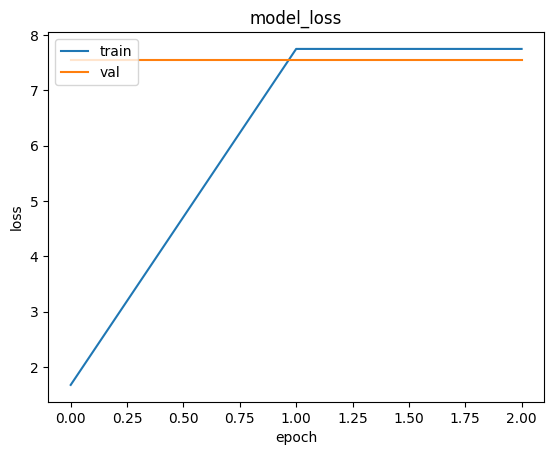

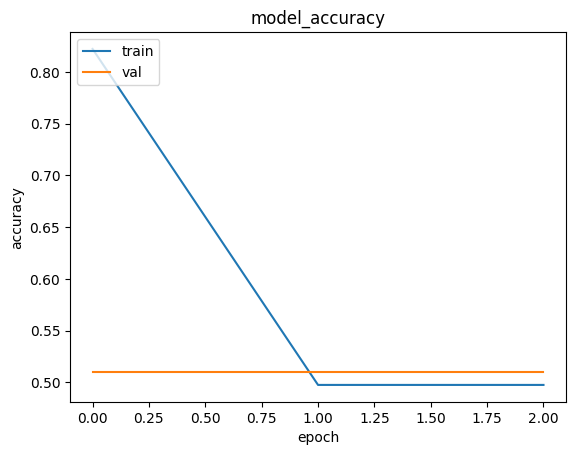

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Demo

In [14]:
input_texts = [
    "Jokowi maju jadi presiden ketiga kali",
    "Makan nasi bisa tambah gemuk?"
]
inputs = tokenizer(input_texts, padding=True,return_tensors="tf")
logits = model(**inputs).logits
print(logits)

# Apply softmax to logits to get probabilities
probabilities = tf.nn.softmax(logits, axis=-1)
# Print the probabilities
print(probabilities)

tf.Tensor(
[[-1.4999197]
 [-1.4126077]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)
